In [1]:
from datetime import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj


%matplotlib inline

In [2]:
def latlon_to_ny(lat, lon):
   """ lat/lon to NYS """

   proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
   result = proj(lon, lat)

   return result

def ny_to_latlon(ny_lat, ny_lon):
    """ NYS to lat/lon """

    proj   = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(ny_lat, ny_lon, inverse=True)

    return result[1], result[0]

In [3]:
def Bird_Count(dbz):
    # get count for birds crossing 1.6km line in 1 hour
    # count = birds per 1.6km/hr
    count = (30.108 * (dbz**3)) - (1168.65 * (dbz**2)) + (15538.004 * dbz) - 59711.238
    
    # 1.6km to 100m
    # count = birds per 100m/hr
    count = count * 18.75
    
    # 1 hour to 10 minutes
    # count = birds per 100m/10min
    count = count / 6
    return count

In [4]:
directory1 = 'data/09/28/'
directory2 = 'data/09/29/'

# for processing each file
csv_df = pd.DataFrame()
# final df
df = pd.DataFrame()


for filename in os.listdir(directory1) + os.listdir(directory2):
    if filename.endswith(".csv"):
        try:
            csv_df = pd.read_csv(directory1 + filename,index_col=0)
        except FileNotFoundError:
            csv_df = pd.read_csv(directory2 + filename,index_col=0)
            
        #csv_df = csv_df.drop(['Unnamed: 0'], axis=1)
        csv_df['Date_Time'] = pd.to_datetime(filename[4:19],format='%Y%m%d_%H%M%S')
        df = df.append(csv_df)

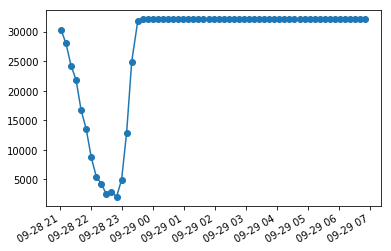

In [5]:
df.Date_Time.value_counts().sort_index().plot(style='-o')

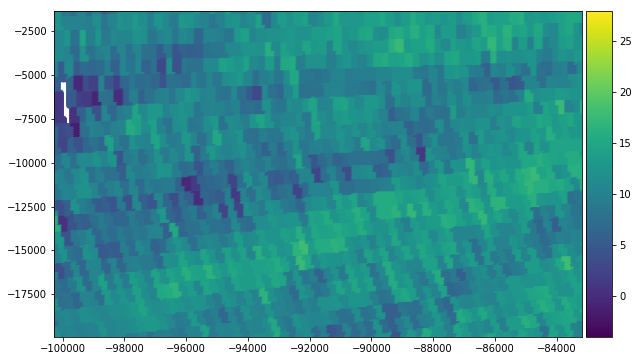

In [11]:
from IPython.display import HTML
from matplotlib import animation
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_video(frame):
    fig, ax = plt.subplots(figsize=(10, 6))
    divider = make_axes_locatable(ax)

    cax = divider.append_axes('right', size='5%', pad=0.05)

    scatter = ax.scatter([frame["s1"].min(), frame["s2"].min()], 
                         [frame["s1"].min(), frame["s2"].min()],
                         c=[frame["DBZH"].min(), frame["DBZH"].max()])
    print(scatter)
    ax.set_xlim([frame["s1"].min(), frame["s1"].max()])
    ax.set_ylim([frame["s2"].min(), frame["s2"].max()])
    def init():
        return scatter
    
    dates = np.sort(frame.Date_Time.unique())
    def update_scatter(i):
        xy = frame[frame.Date_Time == dates[i]]
        scatter.set_offsets(xy[['s1', 's2']])
        scatter.set_array(xy['DBZH'])
        return scatter,

    anim = animation.FuncAnimation(fig, update_scatter,
                                   frames=len(dates), interval=200)
    fig.colorbar(scatter, cax=cax)

    return anim
HTML(plot_video(df).to_html5_video())

In [12]:
full_index = pd.DataFrame(np.array(np.meshgrid(df.Date_Time.unique(), df.s1.unique(), 
                                               df.s2.unique())).T.reshape(-1, 3), columns=["Date_Time", "s1", "s2"])
df = df.set_index(["Date_Time", "s1", "s2"])
full_df = pd.concat([full_index, pd.DataFrame(np.zeros((full_index.shape[0], 1)))], axis=1)

columns = ["Date_Time", "s1", "s2"] + list(df.columns)

In [13]:
full_df = pd.concat([full_index, pd.DataFrame(np.zeros((full_index.shape[0], 5)),
                       columns=df.columns)], axis=1)
full_df["Date_Time"] = pd.to_datetime(full_df["Date_Time"])
full_indexed = full_df.set_index(["Date_Time", "s1", "s2"])
joined = full_indexed.join(df, lsuffix='_delete')
joined = joined[[j for j in joined.columns if "_delete" not in j]]

In [14]:
len(joined[joined.DBZH.isnull()]), len(joined[~joined.DBZH.isnull()])

(279388, 1682616)

count    32164.0
mean        61.0
std          0.0
min         61.0
25%         61.0
50%         61.0
75%         61.0
max         61.0
Name: DBZH, dtype: float64

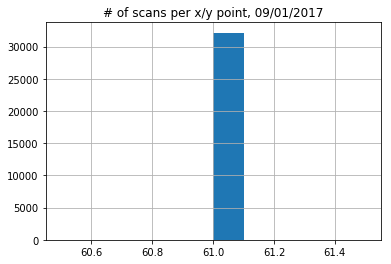

In [15]:
imputed = joined.fillna(0)
imputed = imputed.reset_index()
ax = imputed.groupby(["s1", "s2"]).Date_Time.count().hist()
ax.set_title("# of scans per x/y point, 09/01/2017")
imputed.groupby(["s1", "s2"]).DBZH.count().describe()

## All values

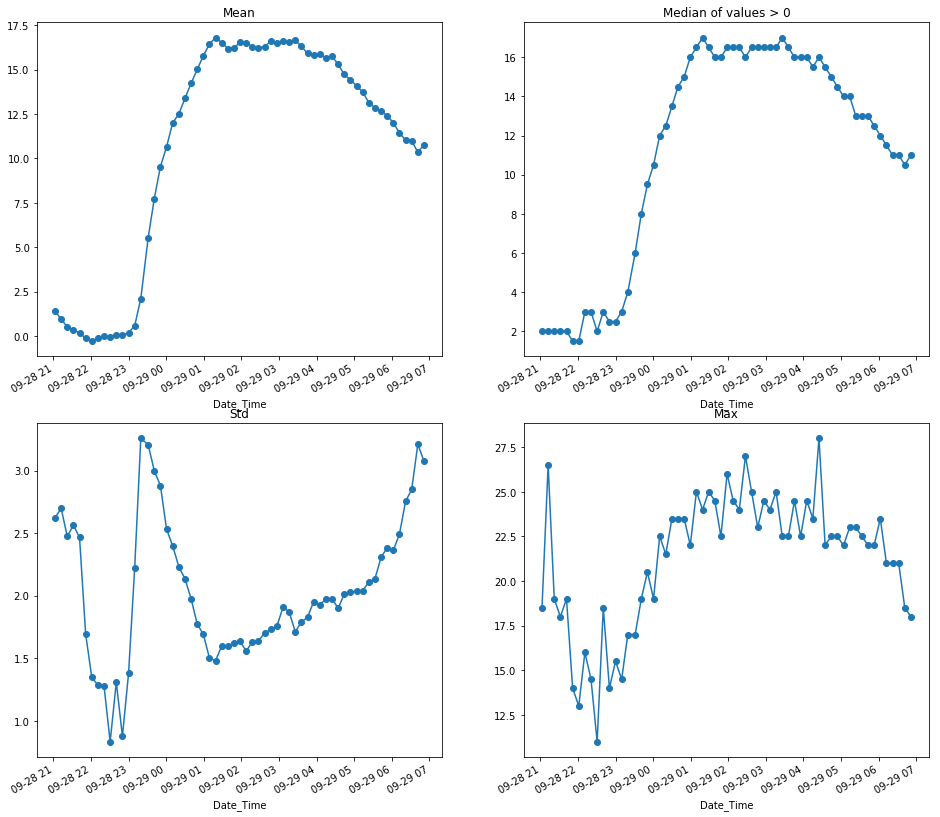

In [16]:
def plot_ts(radar_df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 15))
    axes = axes.flatten()
    for func, ax in zip(['mean', 'median', 'std', 'max'], axes):
        x = radar_df if func != 'median' else radar_df[radar_df.DBZH > 0]
        res = getattr(x.groupby("Date_Time").DBZH, func)()
        res.plot(ax=ax, style='-o')
        ax.set_title(func.title() if func != 'median' else "Median of values > 0")
plot_ts(imputed)

## Weather cut

1962004 1962004 1.0


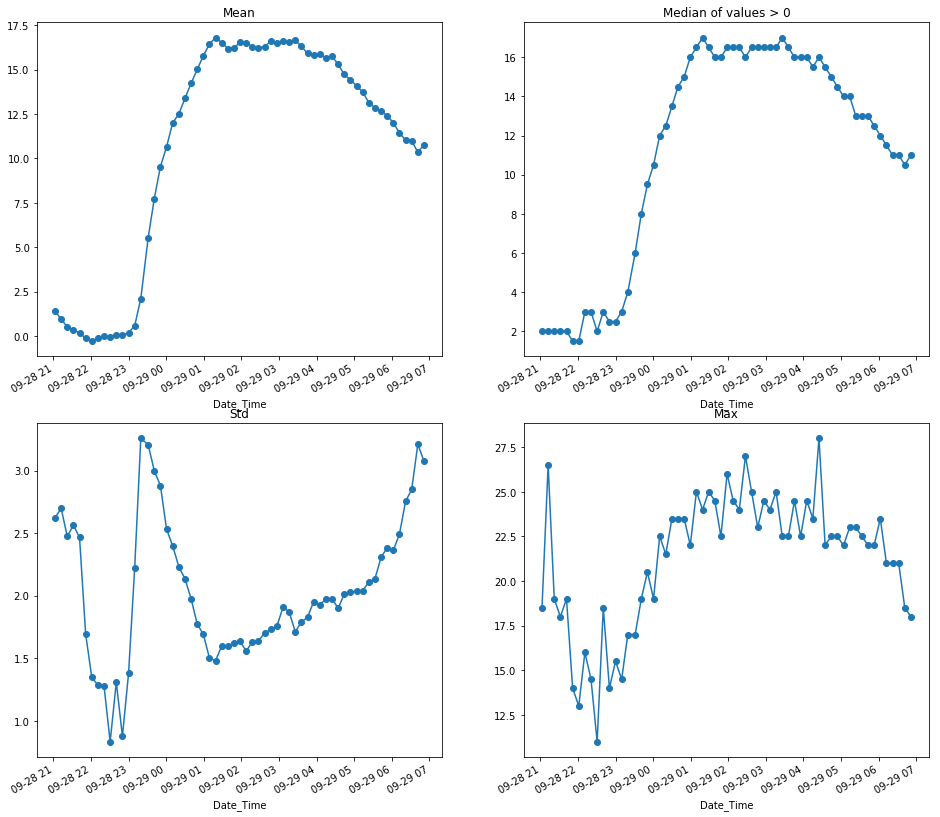

In [17]:
good_weather = imputed[imputed['DBZH'] < 35]
print(len(imputed), len(good_weather), len(good_weather) / len(imputed))
plot_ts(good_weather)

## Insect cut

=== insects, first cut ===
1962004 1894299 0.965491915408939

=== insects, second cut ===
1962004 1543392 0.7866405980823689


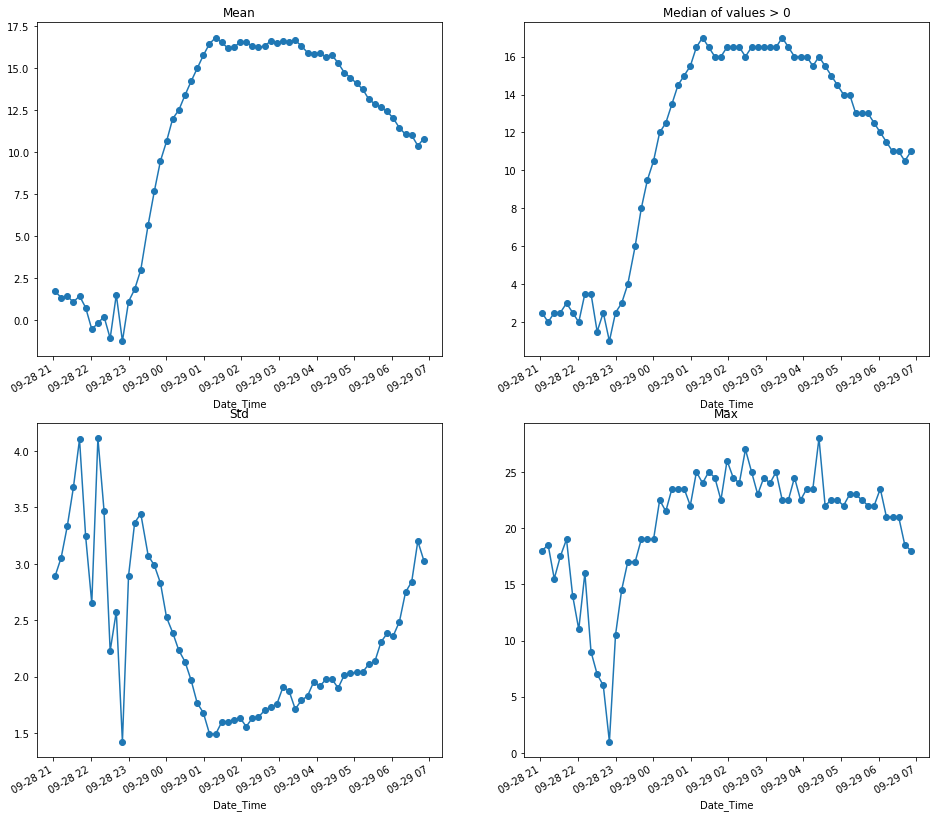

In [18]:
# isolate birds
no_insect_1 = good_weather[good_weather['RHOHV'] <= 0.95]
print("=== insects, first cut ===")
print(len(imputed), len(no_insect_1), len(no_insect_1) / len(imputed))


no_insect_2 = no_insect_1[(no_insect_1['VRADH'] >= 1 )| \
                          (no_insect_1['VRADH'] <= -1)]
print("\n=== insects, second cut ===")
print(len(imputed), len(no_insect_2), len(no_insect_2) / len(imputed))
plot_ts(no_insect_2)

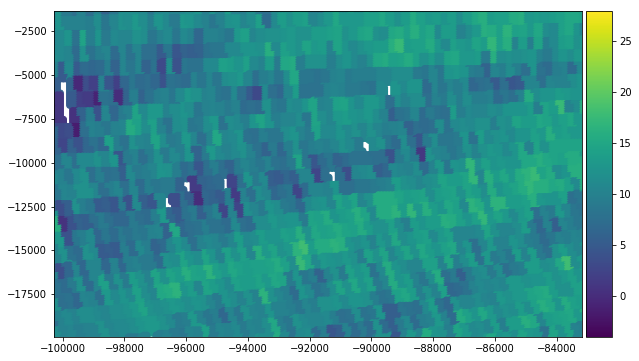

In [19]:
HTML(plot_video(no_insect_2).to_html5_video())

### Plots of individual pixels

In [ ]:
len(imputed) / 1000

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))
for i, (s1s2, g) in enumerate(imputed.groupby(["s1", "s2"])):
    if not i % 1000:
        # "mean" of 1 record in each (s1, s2, t) tuple
        vals = g.groupby("Date_Time").DBZH.mean()
        
        vals.plot(style='-o', ax=ax1)
        sorted_arr = vals.sort_index()
        ax2.plot(sorted_arr.index[1:], sorted_arr.values[1:] - sorted_arr.values[:-1])
ax1.set_title("Values of sampling of 1700 radar pixels")
ax2.set_title("Noise on 1700 radar pixels")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))
for i, (s1s2, g) in enumerate(good_weather.groupby(["s1", "s2"])):
    if not i % 1000:
        # "mean" of 1 record in each (s1, s2, t) tuple
        vals = g.groupby("Date_Time").DBZH.mean()
        
        vals.plot(style='-o', ax=ax1)
        sorted_arr = vals.sort_index()
        ax2.plot(sorted_arr.index[1:], sorted_arr.values[1:] - sorted_arr.values[:-1])
ax1.set_title("Values of sampling of 1700 radar pixels, weather cut")
ax2.set_title("Noise on 1700 radar pixels, weather cut")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))
for i, (s1s2, g) in enumerate(no_insect_2.groupby(["s1", "s2"])):
    if not i % 1000:
        # "mean" of 1 record in each (s1, s2, t) tuple
        vals = g.groupby("Date_Time").DBZH.mean()
        
        vals.plot(style='-o', ax=ax1)
        sorted_arr = vals.sort_index()
        ax2.plot(sorted_arr.index[1:], sorted_arr.values[1:] - sorted_arr.values[:-1])
ax1.set_title("Values of sampling of 1700 radar pixels, final cut")
ax2.set_title("Noise on 1700 radar pixels, final cut")

# Convert radar (x,y) meters from KOKX to lat long 

In [ ]:
# kokx location
kokx_lat = 40.865531
kokx_lon = -72.863944

# convert kokx latlong to feet
kokx_ft = latlon_to_ny(kokx_lat,kokx_lon)
kokx_ft

In [ ]:
ny_to_latlon(kokx_ft[0],kokx_ft[1])

In [ ]:
# convert meters to feet
imputed['s1'] = imputed['s1'] * 3.28084
imputed['s2'] = imputed['s2'] * 3.28084

imputed.head()

In [ ]:
# reorient s1 and s2 with kokx location in state plane
# s1 is x, add kokx_ft x
# s2 is y, add kokx_ft y

imputed['s1'] = imputed['s1'] + kokx_ft[0]
imputed['s2'] = imputed['s2'] + kokx_ft[1]

imputed.head()

In [ ]:
imputed['latlon'] = imputed[['s1','s2']].apply(lambda x: ny_to_latlon(x['s1'], x['s2']), axis=1)

imputed['lat'] = imputed['latlon'].apply(lambda  x : x[0])
imputed['lon'] = imputed['latlon'].apply(lambda  x : x[1])

imputed.drop(columns=['latlon'],inplace=True)

In [ ]:
imputed.head()

In [ ]:
# isolate to Manhattan below central park

imputed = imputed[(imputed['lat'] >= 40.696417 ) & (imputed['lat'] <= 40.766791)]
imputed = imputed[(imputed['lon'] >= -74.022494) & (imputed['lon'] <= -73.959454)]
len(imputed)

In [ ]:
imputed.head()

In [ ]:
imputed['DBZH'].describe()

In [ ]:
time_list = list(imputed['Date_Time'].dt.day.unique())

In [ ]:
Bird_Count(imputed[imputed['Date_Time'] == '2017-04-24 01:33:55']['DBZH'].mean())

In [ ]:
df.to_csv('KOKX_2017_04_birds.csv',index=False)

In [ ]:
time_list

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['DBZH'],bins=20)
plt.show()

In [ ]:
# cut down to lat long over manhattan